# Indexing and Selecting GPS tracks

Our focus on this section concern the selection process on GPS tracks. Given a selection query q, the objective is to find the GPS tracks whose satisfy a temporal or a spatial properties overlap with q. In addition, the process allows the retrieval of tracks that satisfy this properties with q.

Selection is performed by a selector object, containing an arbitrary number of constraints, combined by OR, AND or XOR operator. Since only a single operator is allowed in the selector, a "global selector" is provided to the users to combine the output of several individual selectors. Again, the output may be combined with OR, AND or XOR.

Constraints may be based on:
- a geometrical shape (Rectangle, circle or polygon in Geometrics). This is the standard type of constraint. Different modes are:

    * MODE_CROSSES: tracks crossing shape interior/boundary are selected
    * MODE_INSIDE : tracks remaining fully inside the shape are selected
    * MODE_GETS_IN: tracks getting in (at least once) shape are selected
    * MODE_INSIDE : tracks getting out (at least once) shape are selected

- a track t as a reference. Available modes are:

    * MODE_CROSSES : tracks  intersecting t (at least once) are selected
    * MODE_PARALLEL: tracks  following t are selected

- a "toll gate" segment, defined by two Coords objects: tracks crossing (at least once) the toll gate are selected 

All these constraint may be provided with an additional time constraint, specifying the time interval (between two ObsTime dates) where crossing / containing / getting in / getting out... operations are tested. Besides, there are two types of selection:

* TYPE_SELECT: tracks abiding by constraints are returned as they are
* TYPE_CUT_AND_SELECT: tracks abiding by constraints are cut and returned

## Let's start by defining our environment

This task is only useful for the online notebook

In [1]:
import matplotlib.pyplot as plt
import os
import sys

#-------------------------------------------------------
# Import de tracklib

module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tracklib as trk

code running in a no qgis environment
code running in a no qgis environment


## Loading the GPS track

In [2]:
import matplotlib.pyplot as plt

trk.ObsTime.setReadFormat("4Y-2M-2DT2h:2m:2sZ")
tracks = trk.TrackReader.readFromGpx('../../../data/gpx/activity_5807084803.gpx')
trace = tracks.getTrack(0)

# Transformation GEO coordinates to ENU
trace.toENUCoordsIfNeeded()
trace.summary()


-------------------------------------
GPS track #activity_5807084803 of user 0:
-------------------------------------
  Nb of pt(s):   190
  Ref sys id   : ENU
  Starting at  : 11/11/2020 15:39:54
  Ending at    : 11/11/2020 15:52:00
  Duration     : 726.000 s
  Length       : 2412.144 m
-------------------------------------



## Create a rectangle to select observation on track

<Axes: title={'center': 'Original track'}, xlabel='E (m)', ylabel='N (m)'>

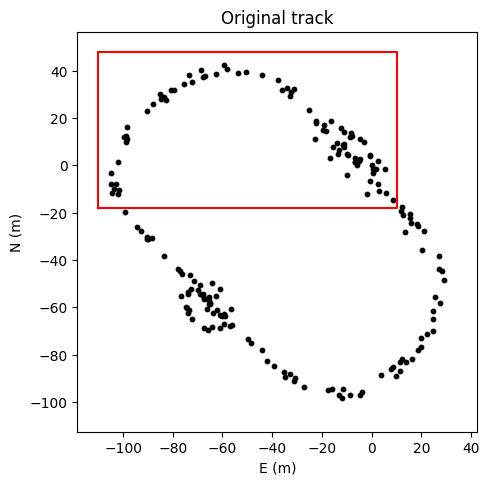

In [3]:
# Plot the GPS track
fig = plt.figure(figsize = (4, 4))
ax = fig.add_axes([0,0,1,1])
trace.plot(sym="ko", pointsize=10, append=ax, title="Original track")

# shape rectangle
ll = trk.ENUCoords(-110, -18)
ur = trk.ENUCoords(10, 48)
bbox = trk.Rectangle(ll, ur)
bbox.plot(append=ax)

## Create a time intervall to select observation on track

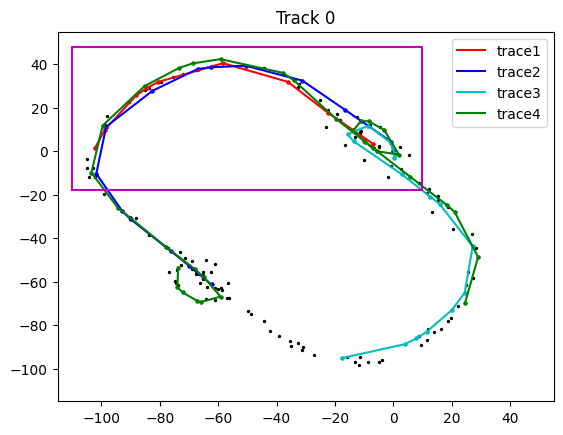

In [4]:
# Time Constraint
tc1 = trk.TimeConstraint(begin=trk.ObsTime('2020-11-11 15:42:15'), 
                        end=trk.ObsTime('2020-11-11 15:42:45'))
tc2 = trk.TimeConstraint(begin=trk.ObsTime('2020-11-11 15:39:00'), 
                        end=trk.ObsTime('2020-11-11 15:40:45'))
tc3 = trk.TimeConstraint(begin=trk.ObsTime('2020-11-11 15:41:15'), 
                        end=trk.ObsTime('2020-11-11 15:42:15'))
tc3 = trk.TimeConstraint(begin=trk.ObsTime('2020-11-11 15:43:55'), 
                        end=trk.ObsTime('2020-11-11 15:45:55'))

trace.plot(sym="ko", pointsize=2, title="Original track")

query  = " SELECT * "
query += " WHERE timestamp <= 2020-11-11 15:42:45 "  # 15:44:15
query += "   AND timestamp >= 2020-11-11 15:42:15 "
trace1 = trace.query(query)
trace1.plot('r-', title='track query by a time constraint', append=True, label='trace1')
trace1.plot('ro', xlabel="", ylabel="", append=True, xlim=[-115, 55], ylim=[-115, 55])

query  = " SELECT * "
query += " WHERE timestamp <= 2020-11-11 15:40:45 "  # 15:44:15
query += "   AND timestamp >= 2020-11-11 15:39:00 "
trace2 = trace.query(query)
trace2.plot('b-', title='track query by a time constraint', append=True, label='trace2')
trace2.plot('bo', xlabel="", ylabel="", append=True, xlim=[-115, 55], ylim=[-115, 55])

query  = " SELECT * "
query += " WHERE timestamp <= 2020-11-11 15:42:15 "  # 15:44:15
query += "   AND timestamp >= 2020-11-11 15:41:15 "
trace3 = trace.query(query)
trace3.plot('c-', title='track query by a time constraint', append=True, label='trace3')
trace3.plot('co', xlabel="", ylabel="", append=True, xlim=[-115, 55], ylim=[-115, 55])

query  = " SELECT * "
query += " WHERE timestamp <= 2020-11-11 15:45:55 "  # 15:44:15
query += "   AND timestamp >= 2020-11-11 15:43:55 "
trace4 = trace.query(query)
trace4.plot('g-', title='track query by a time constraint', append=True, label='trace4')
trace4.plot('go', xlabel="", ylabel="", append=True, xlim=[-115, 55], ylim=[-115, 55])

bbox.plot('m-', append=True)
plt.legend()

## Geometrical shape constraint 

A constraint based on a geometrical shape (red rectangle) and mode CROSSES to select tracks crossing shape interior/boundary.
<br/>

The figure on the left shows the track abiding by constraints (crosses the rectangle and timestamp between 15:39 and 15:52) are cut and returned.
```python 
Constraint(shape=bbox, time = tc, type=trk.TYPE_CUT_AND_SELECT, mode=trk.MODE_CROSSES)
```
<br/>

The figure on the right shows the track abiding by constraints (crosses the rectangle and timestamp between 15:39 and 15:52) are returned as they are.
```python 
Constraint(shape=bbox, time = tc, type=trk.TYPE_SELECT, mode=trk.MODE_CROSSES)
```

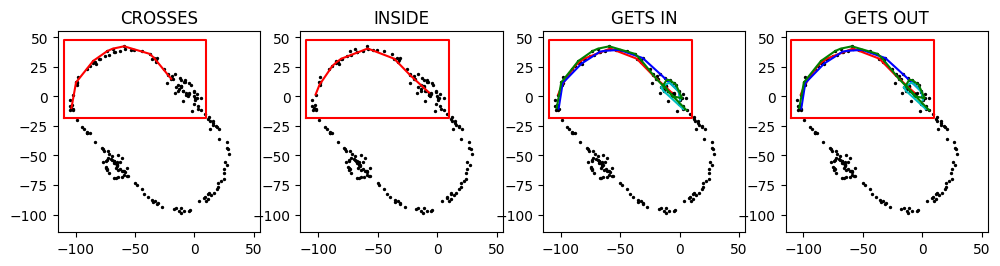

In [8]:
COLORS = ['r', 'b', 'c', 'g']
fig = plt.figure(figsize = (12, 12))

def aff(tracks, i, j, title):
    ax = plt.subplot2grid((4,4), (i-1, j-1))
    trace.plot(sym="ko", pointsize=2, append=ax)
    bbox.plot(append=ax)
    
    for k, track in enumerate(tracks):
        track.plot(sym=COLORS[k]+"-", pointsize=7, append=ax, title=title,
                         xlabel="", ylabel="", xlim=[-115, 55], ylim=[-115, 55])

c21 = trk.Constraint(time=tc1, shape=bbox, type=trk.TYPE_CUT_AND_SELECT, mode=trk.MODE_CROSSES)
trackC21 = c21.select(trk.TrackCollection([trace]))
aff (trackC21, 1, 1, 'CROSSES')

c22 = trk.Constraint(time=tc1, shape=bbox, type=trk.TYPE_CUT_AND_SELECT, mode=trk.MODE_INSIDE)
trackC22 = c22.select(trk.TrackCollection([trace1]))
aff (trackC22, 1, 2, 'INSIDE')

c23 = trk.Constraint(shape=bbox, type=trk.TYPE_CUT_AND_SELECT, mode=trk.MODE_GETS_IN)
trackC23 = c23.select(trk.TrackCollection([trace1, trace2, trace3, trace4]))
aff (trackC23, 1, 3, 'GETS IN')

c24 = trk.Constraint(shape=bbox, type=trk.TYPE_CUT_AND_SELECT, mode=trk.MODE_GETS_OUT)
trackC24 = c24.select(trk.TrackCollection([trace1, trace2, trace3, trace4]))
aff (trackC24, 1, 4, 'GETS OUT')


## Track constraint